# Metropolis-Hastings MCMC implementation (Julia)

In [178]:
using Plots
using BenchmarkTools
using LaTeXStrings
using Distributions
using Statistics
using Printf

### Create mock data

The mock data we will create is drawn from the distribution $f$ which has PDF 
$$f(v| v_{esc},k) = \frac{k+1}{v_{esc}{}^{k+1}} (v_{esc} - v)^k \quad,\quad v\in[0,v_{esc}]$$

and CDF
$$ \text{CDF}_f(v) =  \left( 1 - \frac{v}{v_{esc}} \right)^{k+1} -1 \quad,\quad v\in[0,v_{esc}]$$

which has inverse 
$$  \text{CDF}_f{}^{-1}(y) = v_{esc}\left[ 1 - (1-y)^{\frac{1}{k+1}}  \right] \quad,\quad y\in[0,1] $$

We need the inverse CDF to generate samples from this distribution. Note also that the log likelihood is given by
$$ Log\left(\text{Likelihood} (D|v_{esc},k)  \right) = \sum_d Log(f(d|vesc,k)  ) $$

for a dataset D consisting of datapoints $d$, where each term is of the form
$$  Log(f(d|vesc,k)  ) =  Log(k+1) - (k+1)Log(v_{esc}) + k~Log(v_{esc} - v) $$

In [179]:
function powerlaw_PDF(v,x)
    vesc,k = x
    return ( (k+1)*(vesc)^(-k-1) ) * (vesc - v)^k
end

function powerlaw_inverse_CDF(y,x)
    vesc,k = x
    return vesc*( 1.0 - (1.0-y)^( 1.0/(k+1.0) ) )
end

powerlaw_inverse_CDF (generic function with 1 method)

### Define helper functions

In [180]:
function generate_samples(N,inverse_CDF::Function,x)
    # To sample from a distribution we perform inverse transform sampling, for which the inverse CDF is required
    uniform_random_numbers = rand(Float64,N)
    
    return map( num -> inverse_CDF(num,x) , uniform_random_numbers )
end

generate_samples (generic function with 1 method)

### Sample from distribution to obtain data which we will fit via MCMC

We generate data with a specific escape velocity and $k$ to use in our parameter fit later

In [181]:
target_vesc = 550.0
target_k = 3.0
target_x = [target_vesc,target_k]
num_samples = 1000

target_data = generate_samples(num_samples,powerlaw_inverse_CDF,target_x);

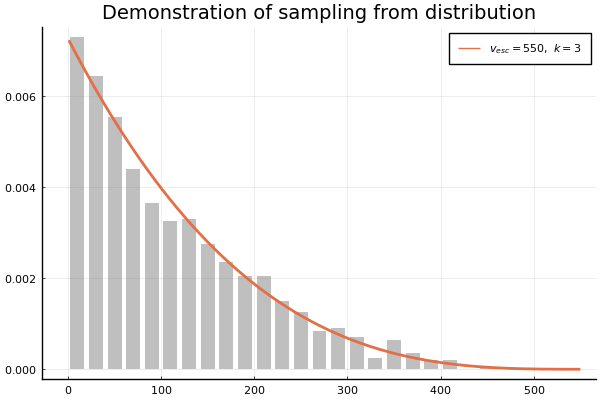

In [182]:
pyplot()

histogram(target_data, normed = true,
                    bins = 25,
                    title = "Demonstration of sampling from distribution",
                    alpha = 0.5,
                    bar_width = 15,
                    linewidth = 0,
                    color = "gray" ,
                    label = ""
                    )

v_test = collect(1:1:550)
plot!(v_test, map(v -> powerlaw_PDF(v,[550.0,3.0]) , v_test) ,
                    linewidth = 2,
                    #color = "red",
                    label = L"v_{esc}=550,~k=3"
                    )

# Define MCMC functions and parameters

In [183]:
function log_prior(x)
    vesc,k = x
    if 100.0 < vesc < 800.0 && 0.2 < k < 10.0 
        return 0.0
    end

    return -Inf
end

function log_likelihood(x,data)
    vesc,k = x
    sum = 0.0
    for v in data
        #println("v = ",v,", vesc = ",vesc)
        if v < vesc && k > 0.0
            sum += log(k+1.0) - (k+1.0)*log(vesc) + k*log(vesc - v)
        else
            return -Inf 
        end
    end
    return sum
end

# Metropolis Hastings-specific functions
function step_model(x)
    #stepping_dist = MvNormal(x,[400.0 0.0 ; 0.0 3])    # has a different normalisation than the python implementation
    stepping_dist_vesc = Normal(x[1], 90.0)     # do it this hacky way for comparison
    stepping_dist_k = Normal(x[2], 0.9)
    return [ rand(stepping_dist_vesc) , rand(stepping_dist_k) ]
end

function step_decision(likelihood_current,likelihood_new)
    if likelihood_new > likelihood_current
        return true
    else
        acceptance_threshhold = rand()
        exp_likelihood_difference = exp(likelihood_new - likelihood_current)

        if exp_likelihood_difference > acceptance_threshhold   
            # Take the step with a small probability proportional to how much "worse" the proposed step is. 
            # Very "bad" steps will have very small probability of being accepted
            return true
        else
            return false
        end
    end
end

step_decision (generic function with 1 method)

# Implement Metropolis-Hastings algorithm

In [184]:
function metropolis_hastings(data, iterations, x0, compute_likelihood::Function, prior::Function, step_model::Function, step_decision::Function)
    x = x0
    accepted_steps = zeros(2,iterations)
    rejected_steps = zeros(2,iterations)
    
    for i in 1:iterations
        
        x_new =  step_model(x)    
        #println(x_new)

        current_likelihood = compute_likelihood(x,data)
        #println("Current likelihood = " , current_likelihood)

        new_likelihood = compute_likelihood(x_new,data) 
        #print(new_likelihood)

        if step_decision( current_likelihood + prior(x) , new_likelihood + prior(x_new) )            
            x = x_new
            accepted_steps[:,i] = x_new
        else
            rejected_steps[:,i] = x_new 
        end         
    end

    return accepted_steps, rejected_steps
end

metropolis_hastings (generic function with 1 method)

# Run MH algorithm

In [243]:
num_steps = 10000
burnin = 200
initial_guess = [600.0,4.0]

quantile_list = [0.16, 0.5, 0.84]

@benchmark accepted, rejected = metropolis_hastings(target_data, 
                                        num_steps,
                                        initial_guess,
                                        log_likelihood, 
                                        log_prior, 
                                        step_model, 
                                        step_decision
                                        )

BenchmarkTools.Trial: 15 samples with 1 evaluation.
 Range (min … max):  327.769 ms … 394.556 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     339.824 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   346.394 ms ±  19.623 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▁    █▁ ▁ ▁ █  ▁     ▁                   ▁▁                ▁  
  ██▁▁▁▁██▁█▁█▁█▁▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  328 ms           Histogram: frequency by time          395 ms <

 Memory estimate: 1.07 MiB, allocs estimate: 10005.

### Strip the zeros

In [186]:
accepted_col_indices = zeros(Int64,0)
rejected_col_indices = zeros(Int64,0)

for (i,col) in enumerate(eachcol(accepted))
    if col != [0,0]
        append!(accepted_col_indices,i)
    end
end

for (i,col) in enumerate(eachcol(rejected))
    if col != [0,0]
        append!(rejected_col_indices,i)
    end
end

accepted_stripped = accepted[:,accepted_col_indices]
rejected_stripped = rejected[:,rejected_col_indices];

In [187]:
length(accepted_stripped) / length(rejected_stripped)

0.0986596352450011

### Process the data

In [188]:
# final data to be used
vesc_posterior = accepted_stripped[1,burnin:end]
k_posterior = accepted_stripped[2,burnin:end]

# Examine acceptance fraction
println(length(accepted_stripped) / length(rejected_stripped)) # a decent proxy for real value

# Establish estimates of parameters via median and expected error on these estimates
vesc_quantiles = quantile(vesc_posterior, quantile_list)
k_quantiles = quantile(k_posterior, quantile_list)


vesc_median = vesc_quantiles[2]
vesc_lower_1sigma = vesc_median - vesc_quantiles[1]
vesc_upper_1sigma = vesc_quantiles[3] - vesc_median

k_median = k_quantiles[2]
k_lower_1sigma = k_median - k_quantiles[1]
k_upper_1sigma = k_quantiles[3] - k_median;

0.0986596352450011


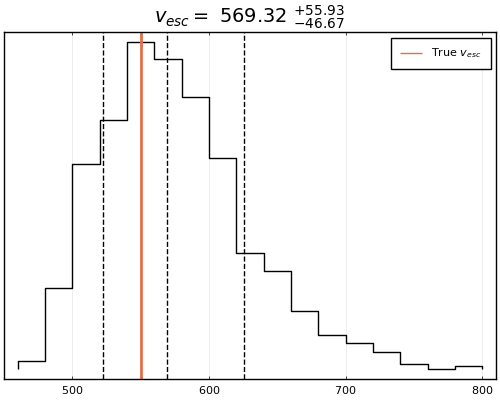

In [236]:
vplot = plot(vesc_posterior, normed = true,
                    bins = 25,
                    title = "\$v_{esc} =\$ $(@sprintf("%.2f", vesc_median)) \$ ^{+$(@sprintf("%.2f", vesc_upper_1sigma))}_{-$(@sprintf("%.2f", vesc_lower_1sigma))}\$ ",
                    #alpha = 0.5,
                    #bar_width = 15,
                    #linewidth = 0,
                    #color = "gray" ,
                    lc="black",
                    label = "",
                    seriestype=:stephist,
                    size=(500,400),
                    #xlabel=L"$v_{esc}$",
                    framestyle = :box,
                    yticks=false
                    )
vline!([target_vesc], lw = 2, label = L"True $v_{esc}$")

vline!(vesc_quantiles , ls=:dash, color="black",lw=1,label="" )

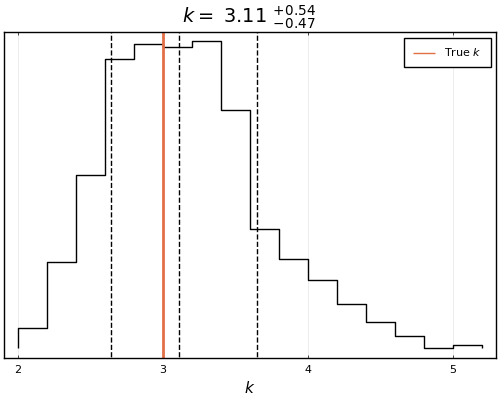

In [237]:
kplot = plot(k_posterior, normed = true,
                    bins = 25,
                    title = "\$k =\$ $(@sprintf("%.2f", k_median)) \$ ^{+$(@sprintf("%.2f", k_upper_1sigma))}_{-$(@sprintf("%.2f", k_lower_1sigma))}\$ ",
                    #alpha = 0.5,
                    #bar_width = 15,
                    #linewidth = 0,
                    #color = "gray" ,
                    lc="black",
                    label = "",
                    seriestype=:stephist,
                    size=(500,400),
                    xlabel=L"$k$",
                    framestyle = :box,
                    yticks=false
                    )
vline!([target_k], lw = 2, label = L"True $k$")

vline!( k_quantiles, ls=:dash, color="black",lw=1, label="")

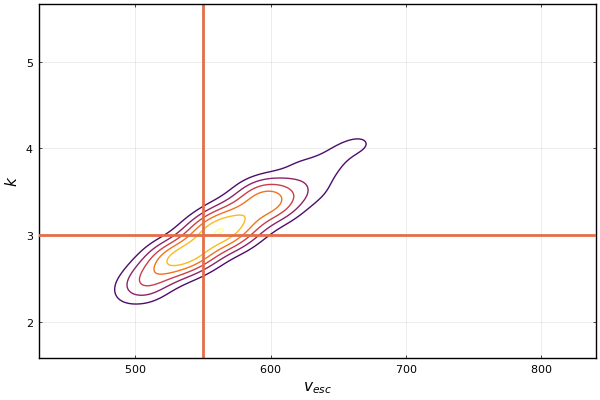

In [240]:
using StatsPlots, KernelDensity
dens = kde((vesc_posterior,k_posterior))
p3 = plot(dens,
    levels = 0.003:0.002:0.014,
    colorbar=false,
    figsize=(400,400),
    xlabel=L"$v_{esc}$",
    ylabel=L"$k$",
    framestyle = :box,
    )

vline!([target_vesc], lw = 2,label="")
hline!([target_k], lw = 2,color=2,label="")

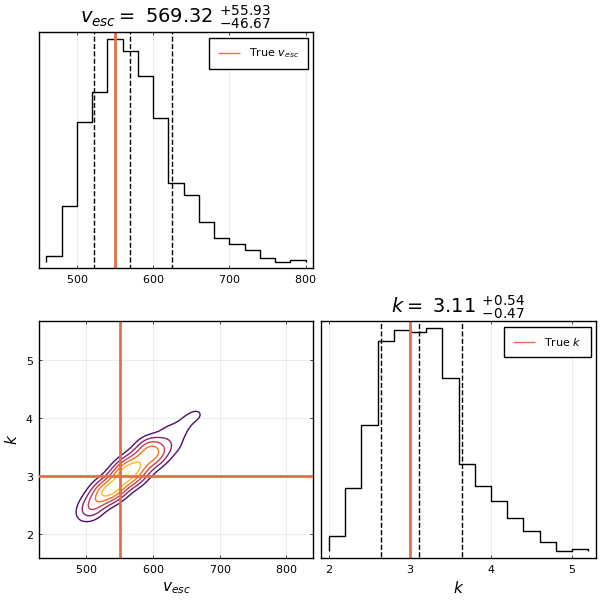

In [241]:
l = @layout [a _ ; b c]

corner = plot(vplot,p3, kplot, layout = l, size=(600,600))

In [242]:
#savefig(corner, "1000_corner_julia_MH.png")